In [4]:
import time
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter

In [38]:
class simulator:
    def __init__(self, vinit) -> None:
        self.v_prev = vinit

    def voltage_calculator(self,vd,vc):
        v_ch = vc
        v_next = self.v_prev + (v_ch - vd)
        self.v_prev = v_next
        return v_next
    


class ControlSystem:
    def __init__(self, Kp=0.7,Ki=0.001,Kd=0.3,Vdesired=4) -> None:
        self.Kp=Kp
        self.Ki=Ki
        self.Kd=Kd
        self.v_desired = Vdesired
        self.last_time = time.time()
        self.sample_time = 1
        self.windup_guard = 10.0
        self.last_error=0
        self.PTerm=0
        self.ITerm=0
        self.DTerm=0
        self.Vdleast=0.12
        self.Vdhigh=1.2

    def calcerror(self,v_curr):
        error = (self.v_desired-v_curr)
        self.current_time =  time.time()
        delta_time = self.current_time - self.last_time
        delta_error = error - self.last_error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time
        
        self.last_time = self.current_time
        self.last_error = error
        return (self.PTerm + (self.Ki*self.ITerm) + (self.Kd*self.DTerm))

    def get_charging_voltage_pwm(self, time):
        if((time>5 and time<10) or (time>15 and time<20) or (time>25 and time<30) or (time>35 and time<40)):
            return 0
        else:
            vc=0.5
            return vc

    def get_charging_voltage_wholeday(self, time):
        if((time>7 and time<18)):
            return 0.5
        else:
            return self.Vdleast

    def get_charging_voltage(self, time):
        c=0.7
        rand = random.randint(1,10)
        r = random.random()
        if((int(rand)%2)==0):
            vc=c + (r*0.05*c)
        else:
            vc=c - (r*0.05*c)
        return vc
            

    def calcv_d(self,error,i):
        vc = self.get_charging_voltage(i)
        vd = vc - error
        # Clamping
        if(vd<=self.Vdleast):
            vd=self.Vdleast
        elif(vd>=self.Vdhigh):
            vd=self.Vdhigh
        return vd,vc


    def calculate_vd(self,v_curr,i):
        error = self.calcerror(v_curr)
        vd,vc = self.calcv_d(error,i)
        return (vd, vc)


def calculate_period(voltage=0.12):
    Estorage=540 #mWm
    Vdd=3
    Ia = 3
    Is = 0.0017
    Cperiod = 60
    T=[10,30,50]
    C=[1,2,3]
    Tnom=13.2  
    
    U=[]
    Vrange=1.2

    Et = Estorage*(voltage/Vrange)
    Ta = (((Et/Vdd)-0/102)/2.9983)
    alpha = Ta/Tnom
    
    for i in range(0,len(T)):
        T[i] = T[i]/alpha
        U.append(C[i]/T[i])

    print(U)
    Uoverall=Ta/Cperiod

    # print("Alpha: {}\t T1: {}\t T2: {}\t Ta={}\t Tb={}".format(alpha,T1,T2,Ta,60-Ta))
    return alpha,Ta,Uoverall, U, T



In [41]:
vcurr = 3.2
sim = simulator(vcurr)
cs = ControlSystem()
time.sleep(2)
print("Starting PID controller with Vinit = {}, Kp = {}, range of Vd:[0.1,0.3]\n".format(vcurr,cs.Kp))

print("Time\t Vd\t VNext\t VCharging")
i=0
voltages=[]
charging_voltages=[]
discharge_voltages=[]
times=[]
Tactive=[]
U=[]
U1=[]
U2=[]
U3=[]
T1=[]
T2=[]
T3=[]
while(True):
    if(i>24):
        break
    voltages.append(vcurr)
    vd,vc = cs.calculate_vd(vcurr,i)
    vcurr = sim.voltage_calculator(vd,vc)
    print("{}\t{}\t{}\t{}".format(i,vd,vcurr,vc))
    time.sleep(1)
    charging_voltages.append(vc)
    discharge_voltages.append(vd)
    times.append(i)
    (alpha,Ta,u, uall, tall) = calculate_period(vd)
    Tactive.append(Ta)
    T1.append(tall[0])
    T2.append(tall[1])
    T3.append(tall[2])
    U.append(u)
    U1.append(uall[0])
    U2.append(uall[1])
    U3.append(uall[2])
    i+=1

    

Starting PID controller with Vinit = 3.2, Kp = 0.7, range of Vd:[0.1,0.3]

Time	 Vd	 VNext	 VCharging
0	0.12	3.7802339769984328	0.7002339769984325
[0.045480317634538366, 0.03032021175635891, 0.02728819058072302]
1	0.7517833441326341	3.7620452990824234	0.7335946662166248
[0.2849278773625639, 0.1899519182417093, 0.17095672641753837]
2	0.5393552467275295	3.9361227332293214	0.7134326808744277
[0.2044170661585238, 0.13627804410568253, 0.12265023969511428]
3	0.7148164227987607	3.930782985234468	0.7094766748039072
[0.27091731632726757, 0.18061154421817838, 0.16255038979636055]
4	0.6774804553676773	3.983027476332056	0.7297249464652652
[0.2567668858442804, 0.17117792389618694, 0.15406013150656825]
5	0.7021642414510557	3.981464612741459	0.7006013778604585
[0.26612210610673925, 0.17741473740449282, 0.15967326366404352]
6	0.7106229539035259	3.9971357414813946	0.726294082643462
[0.26932798051605233, 0.17955198701070155, 0.1615967883096314]
7	0.6828158367013754	3.996672781174578	0.682352876394559
[0

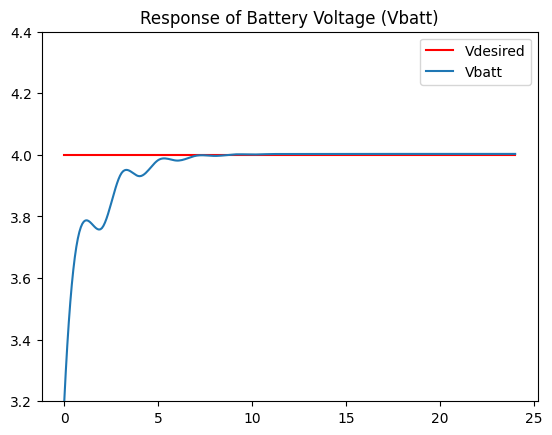

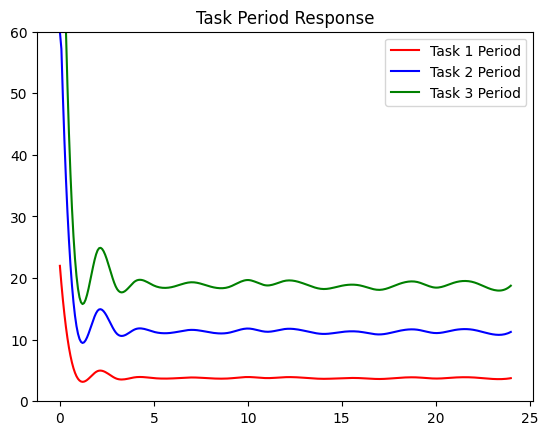

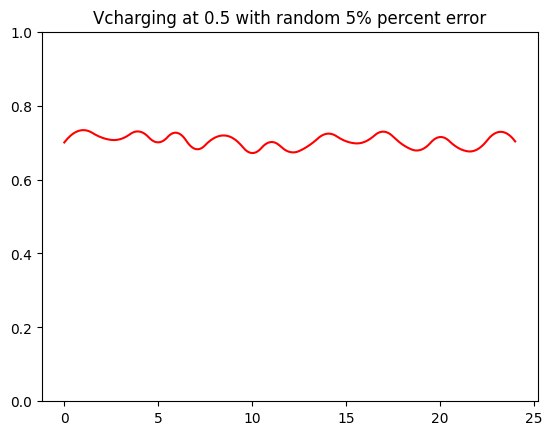

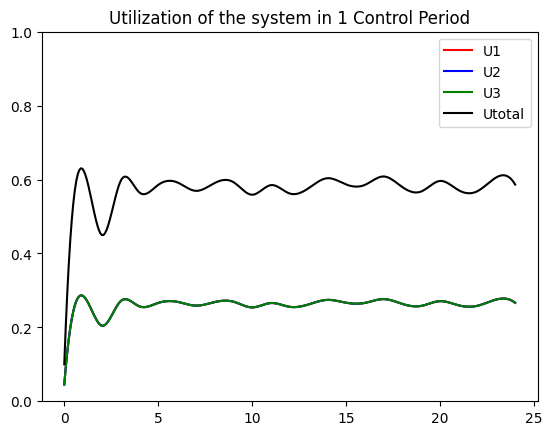

In [42]:
desired_voltages = [cs.v_desired]*len(times)

fig1=plt.gcf()
t = np.linspace(0,24,300)
spl1 = make_interp_spline(np.array(times), np.array(voltages),k=3 )
voltage_smt = spl1(t)
plt.plot(times,desired_voltages,'red', label='Vdesired')
plt.plot(t,voltage_smt, label='Vbatt')
plt.ylim(3.2,4.4)
plt.title('Response of Battery Voltage (Vbatt)')
plt.legend()
plt.show()

T2=np.array(T2)
spl2 = make_interp_spline(np.array(times),np.array(T1), k=3)
spl3 = make_interp_spline(np.array(times),T2, k=3)
spl8 = make_interp_spline(np.array(times),T3, k=3)
spl7 = make_interp_spline(np.array(times),Tactive, k=3)
T1_smt = spl2(t)
T2_smt = spl3(t)
for i in range(0,len(T2_smt)):
    if(T2_smt[i] >60):
        T2_smt[i]=60
T3_smt = spl8(t)
Tactive_smt = spl7(t)
plt.plot(t,T1_smt,'red', label='Task 1 Period')
plt.plot(t,T2_smt,'blue', label='Task 2 Period')
plt.plot(t,T3_smt,'green', label='Task 3 Period')
# plt.plot(t,Tactive_smt,'black', label='System Active Period')
plt.title('Task Period Response')
plt.ylim(0,60)
plt.legend()
plt.show()

spl4 = make_interp_spline(np.array(times), np.array(charging_voltages),k=2)
spl5 = make_interp_spline(np.array(times), np.array(discharge_voltages),k=2)
ch_smt = spl4(t)
dis_smt = spl5(t)
plt.plot(t,ch_smt,'red')
# plt.plot(t,dis_smt)
plt.ylim(0,1)
plt.title('Vcharging at 0.5 with random 5% percent error')
plt.show()

spl6 = make_interp_spline(np.array(times), np.array(U1),k=3)
spl9 = make_interp_spline(np.array(times), np.array(U2),k=3)
spl10 = make_interp_spline(np.array(times), np.array(U3),k=3)
spl11 = make_interp_spline(np.array(times), np.array(U),k=3)
U1smt = spl6(t)
U2smt = spl9(t)
U3smt = spl10(t)
Usmt = spl11(t)
plt.plot(t,U1smt,'red', label='U1')
plt.plot(t,U1smt,'blue', label='U2')
plt.plot(t,U1smt,'green', label='U3')
plt.plot(t,Usmt,'black', label='Utotal')
plt.title('Utilization of the system in 1 Control Period')
plt.ylim(0,1)
plt.legend()
plt.show()

In [31]:
print(T2_smt)

[17.18079003 27.10164023 35.70191579 43.05975104 49.2532803  54.3606379
 58.45995819 60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         59.36843649
 57.46578666 55.57084581 53.76174826 52.11662835 50.71362039 49.63085873
 48.94647769 48.73859645 49.05209828 49.82815769 50.9877773  52.4519597
 54.14170751 55.97802334 57.88190979 59.77436948 60.         60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         60.
 60.         59.91484931 59.60424154 59.56410938 59.76304887 60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.         60.
 60.         60.         60.         60.         60.        